In [1]:
import pandas as pd
from datetime import timedelta
#Data processing
from sklearn import preprocessing

In [2]:
df = pd.read_parquet('../../Sonar/seatunnel_all_information.parquet')

In [3]:
df['total_time']

0       3 days 01:27:48
1       3 days 04:15:10
2       0 days 05:24:03
3       4 days 00:22:26
4      12 days 00:39:27
             ...       
1063    0 days 00:43:10
1064    0 days 19:01:39
1065    0 days 00:16:22
1066    0 days 00:33:35
1067    0 days 00:09:14
Name: total_time, Length: 1068, dtype: timedelta64[ns]

In [4]:
df['time'] = df['total_time'].astype('int64')

In [5]:
df['time']

0        264468000000000
1        274510000000000
2         19443000000000
3        346946000000000
4       1039167000000000
              ...       
1063       2590000000000
1064      68499000000000
1065        982000000000
1066       2015000000000
1067        554000000000
Name: time, Length: 1068, dtype: int64

In [6]:
X = df.loc[:, ~df.columns.isin(['begin_sha', 'end_sha', 'begin_time', 'end_time', 'total_time'])]

In [7]:
cl = list(df['total_time'])


In [8]:
scaler = preprocessing.StandardScaler()
df_scaler = scaler.fit_transform(X)
df_scaler_col = pd.DataFrame(df_scaler)
df_scaler = df_scaler.T

In [9]:
df_scaler.shape

(15, 1068)

In [10]:
scaler_1 = preprocessing.MinMaxScaler()
scaler_1

MinMaxScaler()

In [11]:
df_scaler

array([[-0.42596475, -0.42596475, -0.42596475, ..., -0.3000499 ,
        -0.42596475, -0.42596475],
       [-0.18637973, -0.19174952, -0.1689279 , ..., -0.1467775 ,
        -0.1857085 , -0.1689279 ],
       [-0.10965006, -0.11246059, -0.05062898, ..., -0.06749214,
         0.94336106, -0.11339743],
       ...,
       [ 1.61264794,  1.61264794,  1.61264794, ..., -1.25918689,
        -1.25918689, -1.24951741],
       [ 1.49403151,  1.49403151,  1.49403151, ..., -1.44065797,
        -1.44065797, -1.44065797],
       [-0.06703928, -0.05292508, -0.41142581, ..., -0.43737304,
        -0.43592114, -0.4379746 ]])

In [12]:
#Silhouette analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [13]:
number_of_cluster = []

for i in range(2, len(df_scaler)):
    km = KMeans(n_clusters = i)
    km.fit(df_scaler)
    sil_avg = silhouette_score(df_scaler, km.labels_).round(4)
    number_of_cluster.append([sil_avg , i])

C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with M

In [14]:
print(f'Optimum number of cluster: {max(number_of_cluster)[1]}')

Optimum number of cluster: 3


In [15]:
km

KMeans(n_clusters=14)

In [16]:
import numpy as np

from sklearn.datasets import make_blobs

np.random.seed(0)

batch_size = 45
centers = number_of_cluster
n_clusters = len(centers)
X , labels_true = make_blobs(n_samples=1068, centers=centers, cluster_std=0.7)

In [17]:
import time

from sklearn.cluster import KMeans

k_means = KMeans(init="k-means++", n_clusters=max(number_of_cluster)[1], n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [18]:
from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=max(number_of_cluster)[1],
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [19]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

In [20]:
k_means_labels

array([0, 0, 0, ..., 0, 2, 2], dtype=int64)

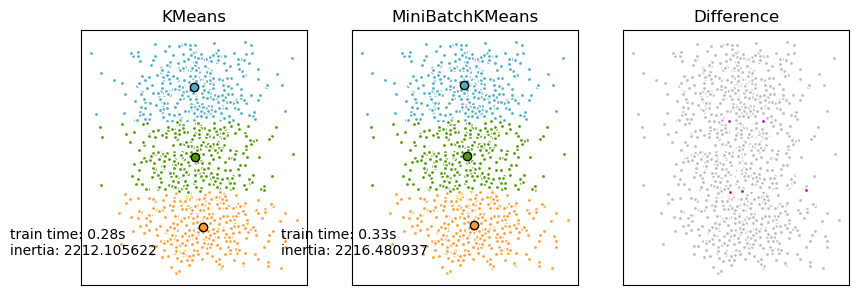

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

# Initialize the different array to all False
different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identical = np.logical_not(different)
ax.plot(X[identical, 0], X[identical, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()

In [22]:
my_members

array([False, False, False, ..., False,  True,  True])

In [23]:
cluster_center

array([0.4313684 , 7.98435298])

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def silhouette(data, n):
	k= range(2,len(df_scaler)) 
	s = []
	# for i in range(2, len(df_scaler)):
    # km = KMeans(n_clusters = i)
    # km.fit(df_scaler)
    # sil_avg = silhouette_score(df_scaler, km.labels_).round(4)
    # number_of_cluster.append([sil_avg , i])

	for n_clusters in k:
		clusters = KMeans(n_clusters = n_clusters, init = 'k-means++')
		clusters.fit(data)
		labels = clusters.labels_
		centroids = clusters.cluster_centers_
		s.append(silhouette_score(data, labels, metric='euclidean'))
		print("Silhouette Coefficient for k == %s: %s" % (
		n_clusters, round(silhouette_score(data, clusters.labels_), 4)))

	fig = plt.figure()
	ax = fig.add_subplot(111)
	ax.plot(k,s,'b*-')
	ax.plot(k[np.argmax(s)], s[np.argmax(s)], marker='o', markersize=12,markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
	plt.ylabel("Silouette Score")
	plt.xlabel("Number of clusters")
	plt.title("Silouette for KMeans clustering")
	plt.show()


In [25]:
cluster1 = np.random.uniform(0.5, 1.5, (2, 10))
cluster2 = np.random.uniform(3.5, 4.5, (2, 10))
cluster3 = np.random.uniform(6.5, 7.5, (2, 10))

[[1.23383998 1.26688868]
 [0.56320482 1.03768803]
 [0.87905445 1.29992882]
 [0.84243352 0.90886803]
 [1.14682152 1.16550279]
 [1.38792077 0.69880421]
 [0.64298979 0.69184457]
 [1.31625375 0.84026241]
 [1.1097234  1.01944051]
 [0.52924269 1.21652679]
 [4.16680482 3.56840085]
 [4.32134456 4.49147111]
 [3.92639692 4.36258931]
 [4.41252925 4.36825775]
 [3.60916772 4.12871306]
 [3.68720331 3.72485568]
 [4.18371758 4.29809155]
 [3.75377268 3.55380057]
 [3.66459055 4.08211534]
 [4.38649374 3.93915964]
 [7.25040683 6.56084243]
 [6.52376813 6.79426854]
 [6.8867855  7.28363674]
 [6.9770944  7.14191425]
 [6.65235923 6.52398485]
 [6.91472019 7.069876  ]
 [7.41047769 6.71734008]
 [6.96863422 7.47574982]
 [6.75177618 7.283687  ]
 [7.03233506 6.6279081 ]]


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 2: 0.6839


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 3: 0.8627


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 4: 0.7198


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 5: 0.5905


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 6: 0.4325


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 7: 0.4712


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 8: 0.4643


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 9: 0.4802


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 10: 0.482


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 11: 0.4474


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 12: 0.4673


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 13: 0.4695


C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Coefficient for k == 14: 0.3832


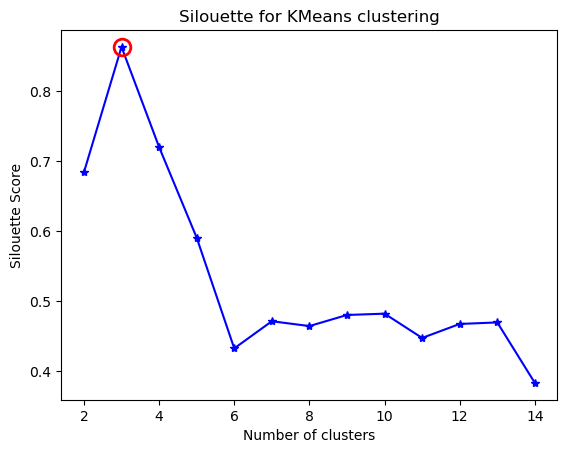

In [26]:
data = np.hstack((cluster1, cluster2,cluster3)).T
print(data)
silhouette(data, 10)

In [27]:
max(number_of_cluster)[1]

3

In [28]:
# Perform KMeans clustering
num_clusters = max(number_of_cluster)[1]
kmeans = KMeans(n_clusters=num_clusters)

In [29]:
cluster_labels = kmeans.fit_predict(X)

C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [30]:
df['cluster'] = cluster_labels

In [31]:
df.head(3)

,begin_sha,end_sha,commits,additions,deletions,changed_files,total_time,begin_time,end_time,begin_Dispensables,...,begin_Change Preventers,begin_Couplers,begin_Object-Orientation Abusers,end_Dispensables,end_Bloaters,end_Change Preventers,end_Couplers,end_Object-Orientation Abusers,time,cluster
0,84be0f9fd057b1680d001de38802ce1c28d79f04,9a2efa51c7180b369ecfea17efaae813d9d0bfc5,1,10,4,3,3 days 01:27:48,2023-06-02T07:22:03Z,2023-06-05T08:49:51Z,500.0,...,262.0,304.0,304.0,500.0,261.0,261.0,304.0,693.0,264468000000000,1
1,84be0f9fd057b1680d001de38802ce1c28d79f04,5e03d22d6cb5bfdaf941b7749e0a313bd6ab2f86,1,2,1,1,3 days 04:15:10,2023-06-02T05:07:40Z,2023-06-05T09:22:50Z,500.0,...,262.0,304.0,304.0,501.0,262.0,262.0,304.0,693.0,274510000000000,1
2,84be0f9fd057b1680d001de38802ce1c28d79f04,e0d8519a9d7b6dfac29c1daf4199b6fe87781d0a,1,36,67,9,0 days 05:24:03,2023-06-02T03:16:04Z,2023-06-02T08:40:07Z,500.0,...,262.0,304.0,304.0,499.0,261.0,261.0,304.0,693.0,19443000000000,1


In [32]:
df.shape

(1068, 21)

In [33]:
df['timedelta'] = pd.to_timedelta(df['time'])

In [34]:
df['formatted_duration'] = df['timedelta'].apply(lambda x: f"{x.days} days {x.seconds // 3600:02d}:{(x.seconds // 60) % 60:02d}:{x.seconds % 60:02d}")

In [35]:
cluster_0 = df[df['cluster'] == 0]
print(cluster_0['timedelta'].min())
print(cluster_0['timedelta'].max())
cluster_0.shape

0 days 00:00:06
110 days 16:44:58


(352, 23)

In [36]:
cluster_1 = df[df['cluster'] == 1]
print(cluster_1['timedelta'].min())
print(cluster_1['timedelta'].max())
cluster_1.shape

0 days 00:00:06
75 days 03:54:20


(362, 23)

In [37]:
cluster_2 = df[df['cluster'] == 2]
print(cluster_2['timedelta'].min())
print(cluster_2['timedelta'].max())
cluster_2.shape

0 days 00:00:05
52 days 17:08:12


(354, 23)